<a href="https://colab.research.google.com/github/TimilsinaSushil/Thesis/blob/main/Coarse_Type_Hyperparameter_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install inltk
!pip install bayesian-optimization



In [ ]:
from inltk.inltk import setup
from inltk.inltk import tokenize
from inltk.inltk import get_embedding_vectors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import asyncio
asyncio.set_event_loop(asyncio.new_event_loop())
setup('ne')


In [3]:
! gdown --id 1SQ6FFd9q_jDoTa39xd2tPjN0yofV7Ysf
df = pd.read_csv('QSN.csv')






/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1SQ6FFd9q_jDoTa39xd2tPjN0yofV7Ysf
To: /content/QSN.csv
100% 1.14M/1.14M [00:00<00:00, 117MB/s]


['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']


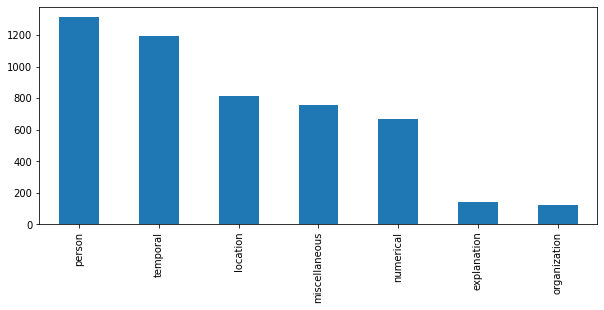

In [4]:
#coarse type filtering
df=df[df['CoarseType'].isin(['location','temporal','numerical','person','organization','explanation','miscellaneous'])]
coarse_type=df['CoarseType'].unique()
print(coarse_type)
plt.figure(figsize=(10,4))
df.CoarseType.value_counts().plot(kind='bar');


**Text Preprocessig**

In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
#removing text inside brackets and quotes
import re
def removeTextInsideQuotesAndBrackets(text):
  text=re.sub("[\(\[].*?[\)\]]", "", text)
  text=re.sub("\'.*?\'","",text)
  text=re.sub('\".*?\"',"",text)
  return text

In [7]:
def removeKo(text):
  words= text.split()
  text=[]
  for word in words:
    length=len(word)
    if(length > 2):
      if(word[-2]=='क' and word[-1]=='ो'):
        if(word!='कसको'):
          word= word[:length-2]
    text.append(word)
  text=' '.join([word for word in text])
  # print(text)
  return text




In [8]:
def preprocessing(questions):
  questions=questions.apply(removeTextInsideQuotesAndBrackets)
  questions = questions.apply(removeKo)
  #tokenization
  questions= questions.apply(lambda x: tokenize(x,'ne'))
  #removing duplicates
  questions= questions.apply(lambda x: list(dict.fromkeys(x)))
  
  questions=questions.apply(lambda x: ' '.join(x).replace('▁','').split())
  questions=questions.apply(lambda x: ' '.join(x))

  #removing numbers
  questios=questions.apply(lambda x: ''.join(c for c in x if not c.isdigit()))
  #removing punctuation
  punctuation=['!','"','#','$','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',"]",'^','_','`','{','|','}','~']
  questions = questions.apply(lambda x: ''.join(c for c in x if c not in punctuation))

  #removing stopwords
  WHWORDS = ['कुन','कहिले','के','कति','को','कसले','कहाँ','कसलाई','कसको','कस्तो','कति','कसरी','किन','कता']
  STOPWORDS = stopwords.words('nepali')
  # Removig WH words from STOPWORDS
  for word in WHWORDS:
    if word in STOPWORDS: STOPWORDS.remove(word)

  STOPWORDS=set(STOPWORDS)
  def clean_text(text):
      text=' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
      return text
  questions = questions.apply(clean_text)
  return questions



In [9]:
df['Questions'] = preprocessing(df['Questions'])

dataset=df

df.head()

,Questions,Answer,CoarseType,FineType,WhWord,Domain
0,नेपाली क्रिकेट टिम क्याप्टेन ज्ञानेन्द्र मल्ल ...,वि.सं. २०७६ कार्तिक १३,temporal,date,कहिले,Sports
1,फ्रान्स लियोन सम्पन्न महिला विश्वकप फुटबल २०१९...,अमेरिका,location,country,कसले,Sports
2,विश्व शान्ति सू चा ंक २०१९ नेपाल कति औ स्थानमा...,७६ औ स्थानमा,numerical,rank,कति,Miscellaneous
3,फलफूल बोट रु दश नोट कार्यक्रम सुरुवात कुन जिल्...,"इच्छाकामना गाउँपालिका, चितवन",location,city,कुन,Politics
4,माथिल्लो त्रिशुली थ्री जल विध ुत आयोजना विधुत ...,वि.स. २०७६ जेठ ०२,temporal,date,कहिले,Miscellaneous


*The topology of a neural network that classifies text is somewhat different than that of the networks presented thus far. It still has a dense layer (or layers), and it still has a sigmoid output layer with one neuron for binary classification or a softmax output layer with one neuron per class for multiclass classification. But preceding those layers are an embedding layer and a flatten layer. The former uses word embeddings to transform arrays, or sequences, of scalar values representing words into arrays of word vectors, which encode information about relationships between words. The latter “flattens” the 2D arrays output by the embedding layer into 1D arrays that can be input to a dense layer.*

In [29]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Questions'])
vocab_size=len(tokenizer.word_index)
sequences = tokenizer.texts_to_sequences(df['Questions'])

*Neural network expects all sequences to be the same length. Keras’s pad_sequences function performs this final step, truncating sequences longer than the specified length and padding sequences shorter than the specified length with 0s:*

In [30]:
from keras.preprocessing.sequence import pad_sequences
maxlen = max([len(i) for i in sequences])
padded_sequences = pad_sequences(sequences, maxlen)
# print(padded_sequences)

*The first hidden layer in a neural network that classifies text is an embedding layer whose job is to convert padded sequences of word indices into arrays of word vectors, which represent each word with an array of floating-point numbers rather than a single integer. Each word in the input text is represented by a vector in the embedding layer, and as the network is trained, vectors representing individual words are adjusted to reflect their relationship to one another. If you’re building a sentiment-analysis model and words such as “excellent” and “amazing” are generally associated with positive sentiment, then the vectors representing those words in the embedding space should be relatively close together so phrases such as “excellent service” and “amazing service” score similarly*

**One hot encoding of labels**

In [31]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
le = preprocessing.LabelEncoder()
y=df.CoarseType;
# print(y.unique())
y = le.fit_transform(y)

**SVM**

In [32]:
def svm(k_fold,test_size,c):
  from sklearn.model_selection import train_test_split
  from sklearn.pipeline import Pipeline
  from sklearn.feature_extraction.text import TfidfTransformer
  from sklearn.feature_extraction.text import CountVectorizer
  from sklearn.svm import SVC
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import fbeta_score
  from sklearn.metrics import classification_report
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.multiclass import OneVsRestClassifier
  import random 
  test_size=0.30
  k_fold = 5
  X = dataset.Questions
  y = dataset.CoarseType
  c=1

  # Splitting test set
  X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=test_size) 

  metrics = []
  skf= StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=1)
  X=np.array(X_train)
  y=np.array(y_train)

  # Defining Model
  model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(SVC(C=c, kernel='rbf'))),    #Non linear svm
              ])

    
    #gaussian
    #sigmoid
  #model defination finished


  # K fold cross validation
  for train_index, validation_index in skf.split(X, y):
      # print("TRAIN:", train_index, "VALIDATION:", validation_index)
      X_train, X_validation = X[train_index], X[validation_index]
      y_train, y_validation = y[train_index], y[validation_index]
  #   # train the model
      model.fit(X_train,y_train)
  #   # validate the model 
      y_pred_class_for_validation = model.predict(X_validation)
      metrics.append(accuracy_score(y_validation, y_pred_class_for_validation))
      # print(classification_report(y_test, y_pred_class,target_names=coarse_type))
      




  metrics = np.array(metrics)
  # print('Validation Accuracy for each Iteration',metrics)
  # print('Mean accuracy for validation set: ', np.mean(metrics, axis=0))
  # print('Std for accuracy: ', np.std(metrics, axis=0))
  # print('---------------------------------------------------------------------------------')

  y_pred = model.predict(X_test)

  test_accuracy = accuracy_score(y_pred, y_test)
  beta_score=fbeta_score( y_pred, y_test, average='weighted', beta=0.5)
  # print('Test Accuracy : %s' % test_accuracy)
  # print(classification_report(y_test, y_pred,target_names=fine_type))

  # cf_matrix = confusion_matrix(y_test, y_pred, labels=fine_type)
  # print(cf_matrix)

  # import seaborn as sns
  # plt.figure(figsize=(8,7))
  # actual_data= ['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']
  # predicted_data= ['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']
  # cm = confusion_matrix(actual_data, predicted_data)
  # ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
  # ax.set_title('Confusion Matrix')
  # ax.set_xlabel('Predicted Intent')
  # ax.set_ylabel('Actual Intent')
  # ax.xaxis.set_ticklabels(['TEM','LOC','NUM','PER','ORG','EXP','MISC'])
  # ax.yaxis.set_ticklabels(['TEM','LOC','NUM','PER','ORG','EXP','MISC'])
  # plt.show()
  
  # return test_accuracy
  return beta_score



**Random Forest**

In [33]:
def randomForest(k_fold,test_size,n_estimators):
  from sklearn.model_selection import train_test_split
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import fbeta_score
  from sklearn.metrics import classification_report
  from sklearn.ensemble import RandomForestClassifier

  x=padded_sequences
  test_size=0.2
  k_fold=5
  # max_depth=2
  n_estimators=100

  x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=test_size) 
  metrics = []
  skf= StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)


  #Create a Gaussian Classifier
  model=RandomForestClassifier(n_estimators=n_estimators)

    # K fold cross validation
  for train_index, validation_index in skf.split(x_train, y_train):
      # print("TRAIN:", train_index, "VALIDATION:", validation_index)
      X_train, X_validation = x_train[train_index], x_train[validation_index]
      Y_train, Y_validation = y_train[train_index], y_train[validation_index]
      
  #   # train the model
      model.fit(X_train,Y_train)
  #   # validate the model 
      Y_pred_class_for_validation = model.predict(X_validation)
      metrics.append(accuracy_score(Y_validation, Y_pred_class_for_validation))
      # print(classification_report(y_test, y_pred_class,target_names=coarse_type))

  # metrics = np.array(metrics)
  # print('Validation Accuracy for each Iteration',metrics)
  # print('Mean accuracy for validation set: ', np.mean(metrics, axis=0))
  # print('Std for accuracy: ', np.std(metrics, axis=0))
  # print('---------------------------------------------------------------------------------')



  y_pred=model.predict(x_test)
  test_accuracy=accuracy_score(y_test, y_pred)
  beta_score=fbeta_score( y_test,y_pred, average='weighted', beta=0.5)

  # print("Test Accuracy:",test_accuracy)
  # return test_accuracy
  return beta_score

**DNN**

In [34]:
def dnn(k_fold,test_size,epochs,learning_rate,batch_size,vect_dim,neurons,dropout):
  from keras.models import Sequential
  from keras.layers import Dense, Flatten, Dropout
  from keras.layers.embeddings import Embedding
  from sklearn.model_selection import train_test_split
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import fbeta_score
  from sklearn.metrics import classification_report

  le = preprocessing.LabelEncoder()
  y=df.CoarseType
  # print(y.unique())
  y = le.fit_transform(y)
  y = to_categorical(y) 

  test_size=0.2
  k_fold=5

  epochs=20
  learning_rate= 0.002
  batch_size=40
  vect_dim=32
  neurons=128
  dropout=0.2



  x=padded_sequences;
  x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=test_size) 
  acc = []
  val = []
  skf= StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)
  # x=np.array(x_train)
  # y=np.array(y_train)

  max_len = max([len(i) for i in sequences])
  # from keras.optimizers import Adam
  model = Sequential() 
  model.add(Embedding(vocab_size + 1, vect_dim, input_length=max_len)) 
  model.add(Flatten())
  model.add(Dense(neurons, activation='relu'))
  # model.add(Dropout(dropout))
  model.add(Dense(7, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy']) 
  #default value of learning rate will be 0.001
  #adam is a variant of SGD(Sochastic gradient descent). Learning rate should be between (0.0001 to 0.1).Objective: Minimize the loss between actual output and predicted output.
  model.optimizer.lr=learning_rate
  # model.summary()

  # K fold cross validation
  i=0
  for train_index, validation_index in skf.split(x_train, y_train.argmax(1)):
      i=i+1
      # print("TRAIN:", train_index, "VALIDATION:", validation_index)
      x_train, x_validation = x[train_index], x[validation_index]
      y_train, y_validation = y[train_index], y[validation_index]
      hist = model.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs=epochs, batch_size=batch_size, verbose=0)
      ac = hist.history['categorical_accuracy']
      # print('Average training accuracy :' +str(sum(ac)/len(ac)))
      vl = hist.history['val_categorical_accuracy']
      # print('Average validation accuracy :' + str(sum(vl)/len(vl)))
      # ep = range(1, len(ac) + 1)
      # plt.figure()
      # plt.plot(ep, ac, '-', label='Training accuracy')
      # plt.plot(ep, vl, ':', label='Validation accuracy')
      # plt.title('Training and Validation Accuracy for set '+ str(i))
      # plt.xlabel('Epoch')
      # plt.ylabel('Accuracy')
      # plt.legend(loc='lower right')
      # plt.plot()
      # acc.extend(ac);
      # val.extend(vl)


  # plt.figure()
  # epochs = range(1, len(acc) + 1)
  # plt.plot(epochs, acc, '-', label='Training accuracy')
  # plt.plot(epochs, val, ':', label='Validation accuracy')
  # plt.title('Overall Training and Validation Accuracy')
  # plt.xlabel('Epoch')
  # plt.ylabel('Accuracy')
  # plt.legend(loc='lower right')
  # plt.plot()


  y_pred = model.predict(x_test)

  test_accuracy = accuracy_score(y_pred.argmax(axis=1), y_test.argmax(axis=1))

  beta_score=fbeta_score( y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted', beta=0.5)
  print('Test Accuracy : %s' % test_accuracy)
  # print(y_pred.argmax(axis=1))
  # print(y_test.argmax(axis=1))
  labels=y.argmax(axis=1)
  labels=le.inverse_transform(labels)
  labels=np.unique(labels)
  # print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=labels))

  mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1),labels=le.fit_transform(df.CoarseType.unique()))
  import seaborn as sns
  plt.figure(figsize=(8,7))
  sns.set()
  sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=df.CoarseType.unique(), yticklabels=df.CoarseType.unique())
  
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')

  # return test_accuracy

  return beta_score




In [35]:
#SVM
from bayes_opt import BayesianOptimization
pbounds = {
    'k_fold': (5, 10), 
    'test_size':(20,50),
    'c':(0.01,1)
    }
optimizer_svm = BayesianOptimization(
    f=svm,
    pbounds=pbounds,
    verbose=2, 
    random_state=42,
)
optimizer_svm.maximize(init_points = 0, n_iter = 20)
print("Best result: {}; Beta Score = {}.".format(optimizer_svm.max["params"], optimizer_svm.max["target"]))

|   iter    |  target   |     c     |  k_fold   | test_size |
-------------------------------------------------------------
|  1        |  0.7959   |  0.3808   |  9.754    |  41.96    |
|  2        |  0.777    |  0.1834   |  8.158    |  22.71    |
|  3        |  0.7673   |  0.3937   |  8.495    |  41.59    |
|  4        |  0.7777   |  0.4738   |  9.735    |  42.07    |
|  5        |  0.7817   |  0.9436   |  6.84     |  26.64    |
|  6        |  0.7828   |  0.8952   |  9.308    |  32.4     |
|  7        |  0.788    |  0.339    |  8.4      |  48.89    |
|  8        |  0.7775   |  0.1035   |  9.006    |  37.87    |
|  9        |  0.7903   |  0.409    |  9.203    |  42.73    |
|  10       |  0.7812   |  0.6142   |  6.107    |  49.28    |
|  11       |  0.7805   |  0.05045  |  7.444    |  37.75    |
|  12       |  0.7669   |  0.3152   |  9.305    |  22.82    |
|  13       |  0.7809   |  0.8321   |  8.196    |  33.73    |
|  14       |  0.7752   |  0.2755   |  6.276    |  35.13    |
|  15   

In [36]:
#Random Forest
pbounds = {
    'k_fold': (5, 10), 
    'test_size':(20,50),
    # 'max_depth':(100,1000),
    'n_estimators':(100,1000),
    }
optimizer_rf = BayesianOptimization(
    f=randomForest,
    pbounds=pbounds,
    verbose=2, 
    random_state=42,
)
optimizer_rf.maximize(init_points = 0, n_iter = 20)
print("Best result: {}; Beta Score = {}.".format(optimizer_rf.max["params"], optimizer_rf.max["target"]))

|   iter    |  target   |  k_fold   | n_esti... | test_size |
-------------------------------------------------------------
|  1        |  0.7633   |  6.873    |  955.6    |  41.96    |
|  2        |  0.7575   |  9.857    |  669.2    |  49.58    |
|  3        |  0.7915   |  6.657    |  956.1    |  40.5     |
|  4        |  0.7636   |  6.626    |  531.2    |  24.28    |
|  5        |  0.762    |  9.715    |  431.1    |  26.64    |
|  6        |  0.7751   |  9.47     |  875.4    |  32.4     |
|  7        |  0.7623   |  6.662    |  711.9    |  48.89    |
|  8        |  0.7893   |  5.472    |  821.1    |  37.87    |
|  9        |  0.7659   |  7.015    |  856.6    |  42.73    |
|  10       |  0.7853   |  8.052    |  299.3    |  49.28    |
|  11       |  0.7879   |  5.204    |  540.0    |  37.75    |
|  12       |  0.7657   |  6.541    |  875.0    |  22.82    |
|  13       |  0.769    |  9.152    |  675.4    |  33.73    |
|  14       |  0.7709   |  6.341    |  329.8    |  35.13    |
|  15   

|   iter    |  target   | batch_... |  dropout  |  epochs   |  k_fold   | learni... |  neurons  | test_size | vect_dim  |
-------------------------------------------------------------------------------------------------------------------------
Test Accuracy : 0.9720558882235529
|  1        |  0.9721   |  43.71    |  0.7704   |  39.28    |  7.993    |  0.001645 |  26.72    |  21.74    |  111.9    |
Test Accuracy : 0.9710578842315369
|  2        |  0.971    |  44.25    |  0.7151   |  40.18    |  5.092    |  0.001748 |  64.88    |  39.76    |  93.82    |
Test Accuracy : 0.9730538922155688
|  3        |  0.9735   |  43.91    |  0.2772   |  35.76    |  9.823    |  0.005932 |  31.93    |  22.94    |  104.0    |
Test Accuracy : 0.9820359281437125
|  4        |  0.9821   |  22.27    |  0.6042   |  30.45    |  5.131    |  0.000649 |  37.76    |  49.14    |  102.8    |
Test Accuracy : 0.9750499001996008
|  5        |  0.9755   |  13.96    |  0.5947   |  22.32    |  5.346    |  0.006318 |  30.71 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


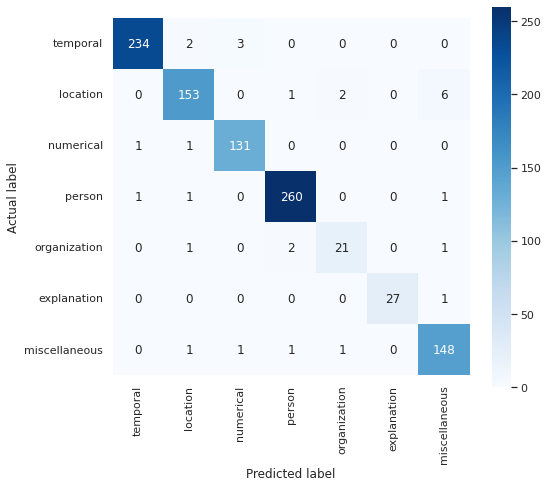

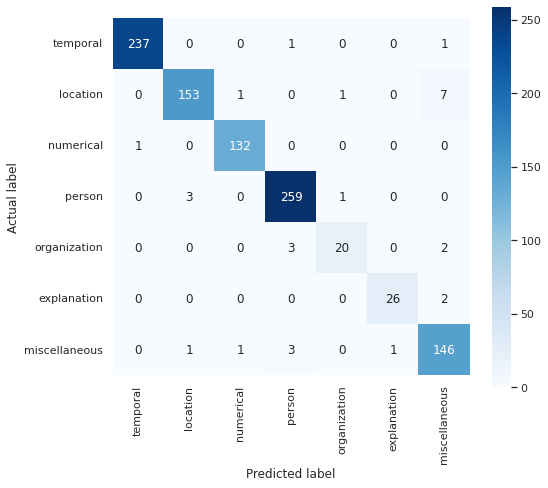

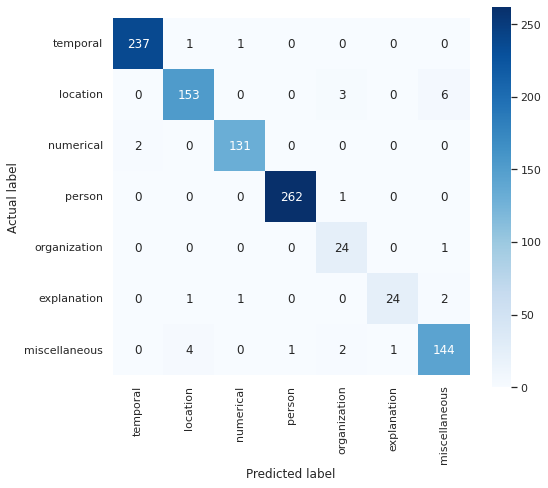

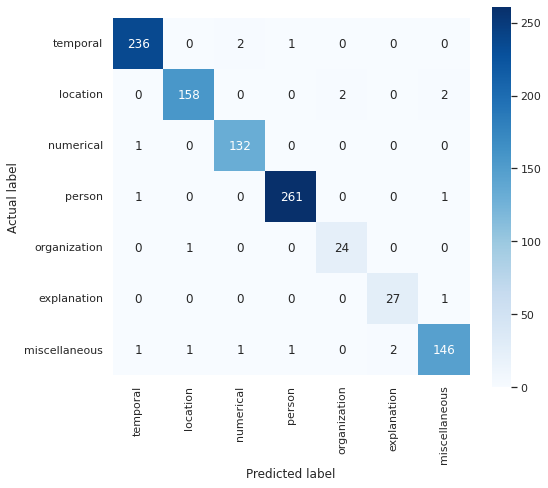

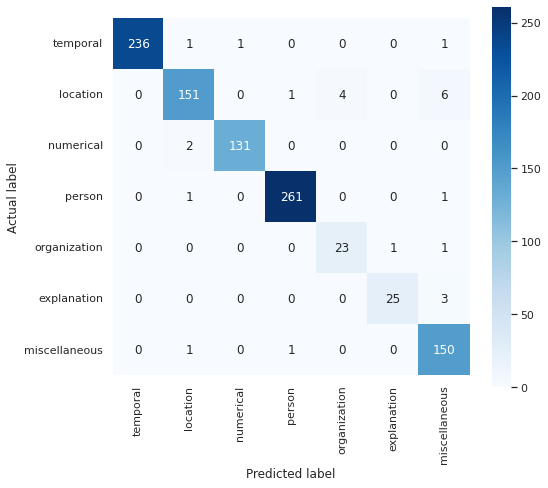

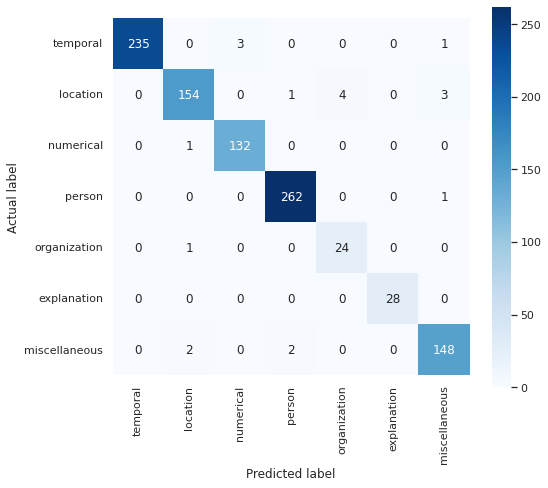

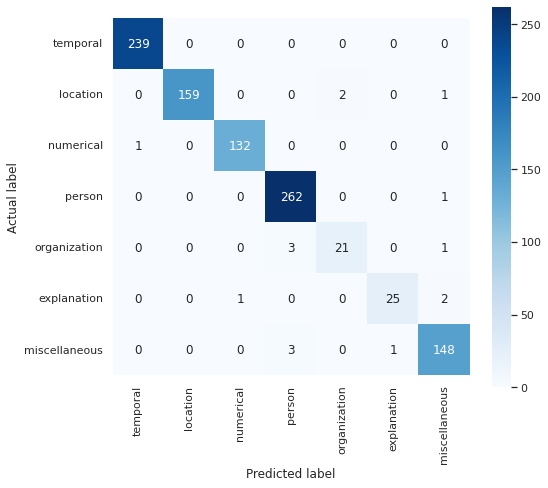

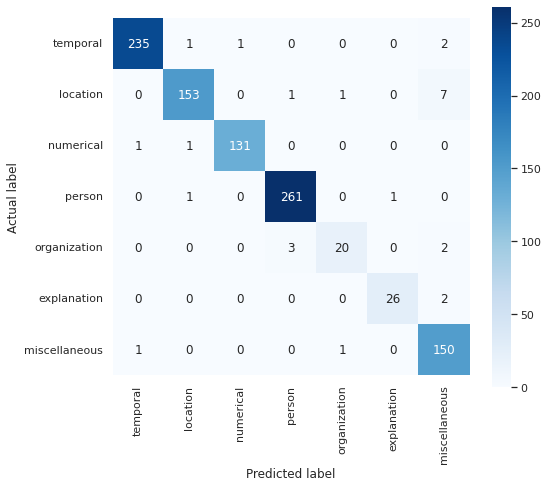

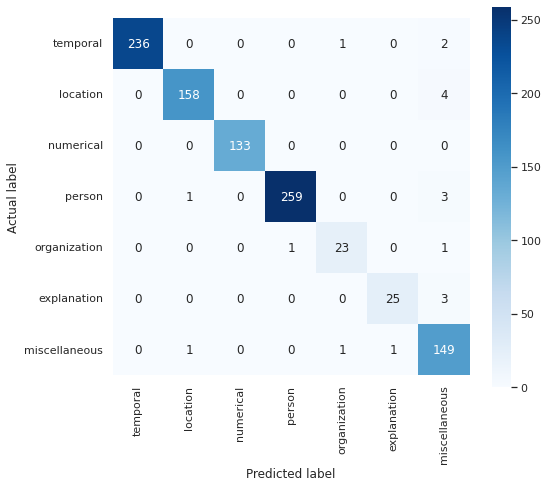

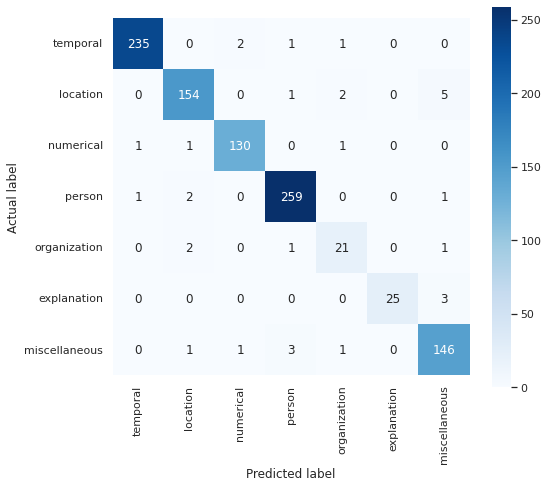

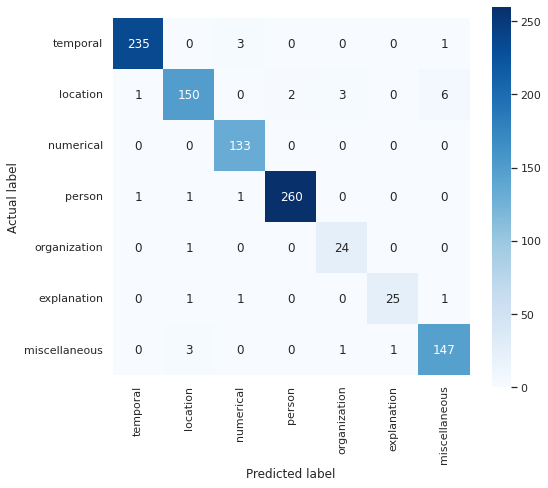

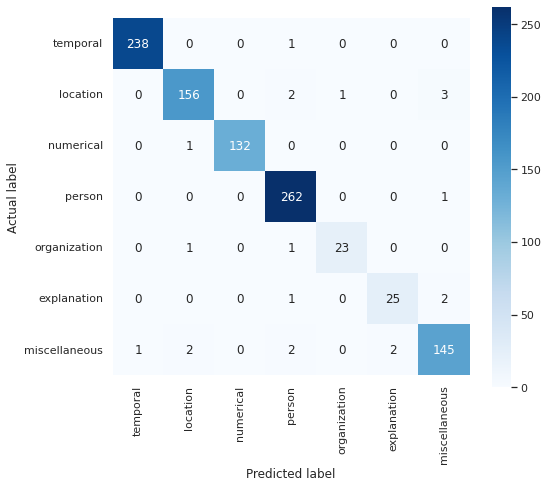

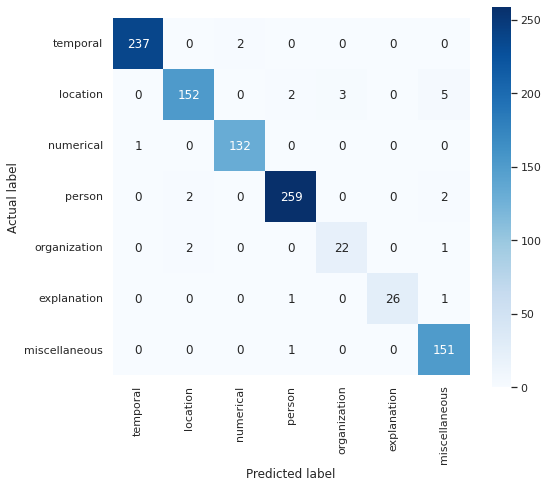

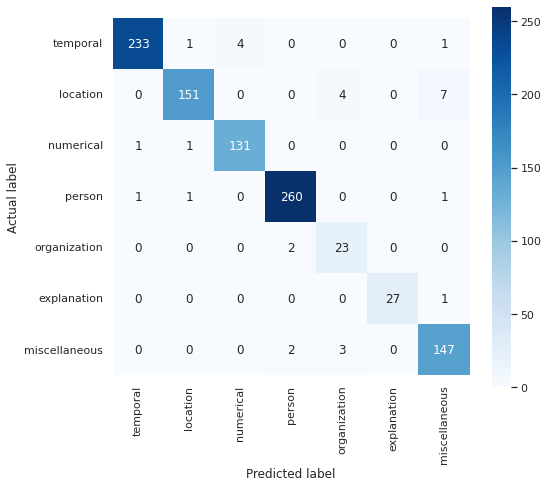

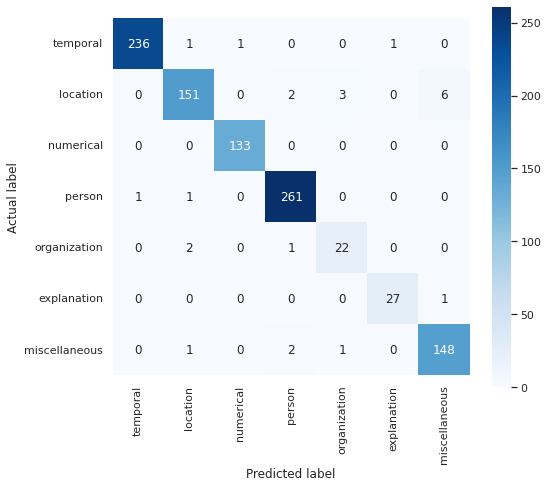

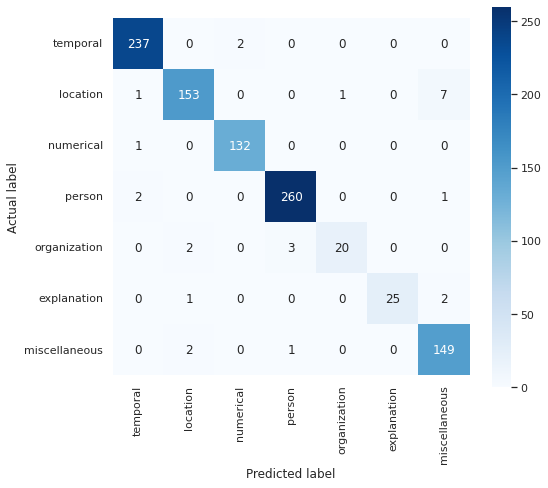

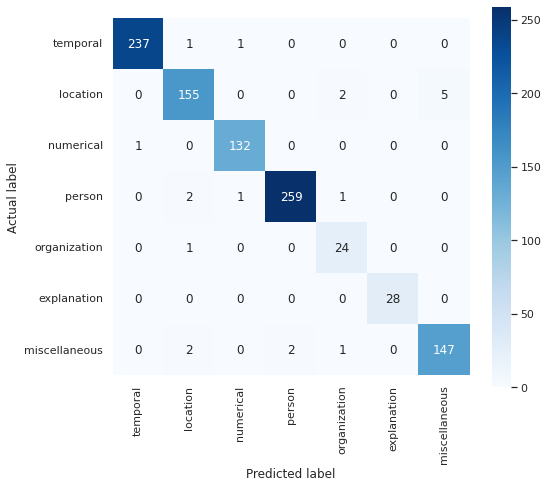

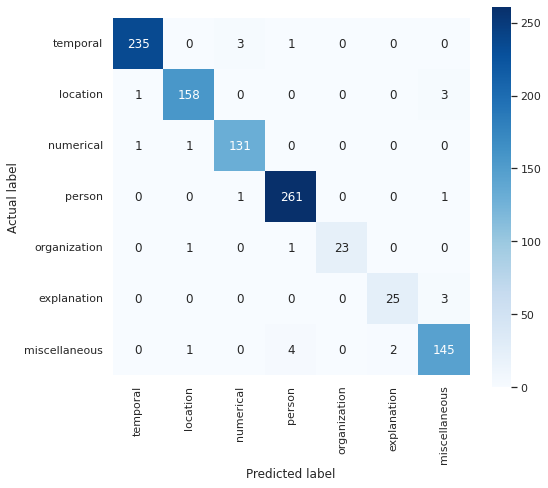

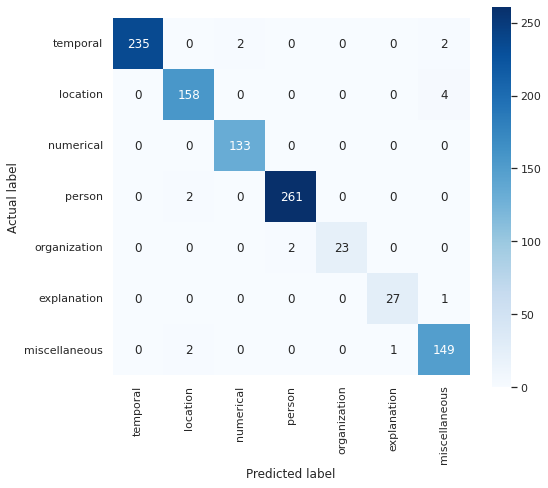

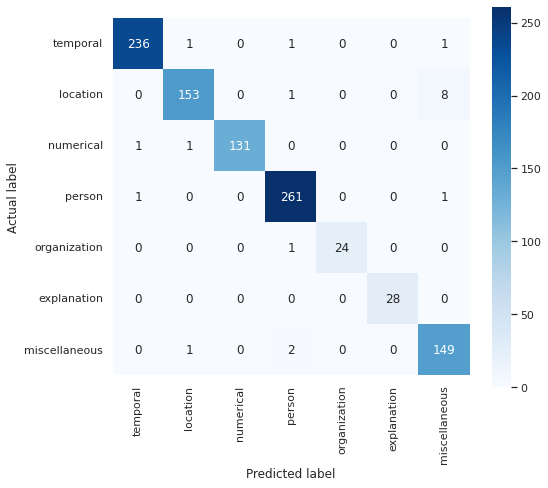

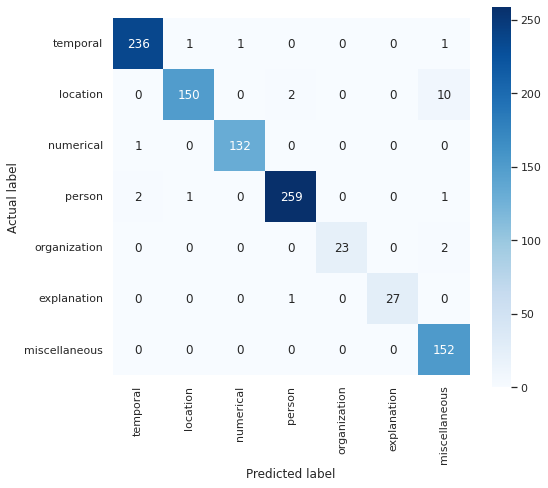

In [37]:
#DNN
pbounds = {
    'k_fold': (5, 10), 
    'test_size':(20,50),
    'epochs': (10,50), 
    'learning_rate':(0.0001,0.01),
    'batch_size': (10, 100), 
    'vect_dim':(8,128),
    'neurons':(8,128),
    'dropout':(0.2,0.8)
    }
optimizer_dnn = BayesianOptimization(
    f=dnn,
    pbounds=pbounds,
    verbose=2, 
    random_state=42,
)
optimizer_dnn.maximize(init_points = 0, n_iter = 20)
print("Best result: {}; Beta Score = {}.".format(optimizer_dnn.max["params"], optimizer_dnn.max["target"]))